# Copper Data Processing

# Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

from constants import (
    RENAME_DICT, TO_LOG10, FEATURES, MIN_TIR,
    FILL_COLS, LOG_INF_REPL, UPPER_LIMIT_TIR
)

# Data Loading

In [3]:
raw_copper_mines_df = pd.read_excel('../../../../data/raw/Cu_v2.xls', decimal=',', thousands='.')

# Preprocessing

In [4]:
#Colunms renaming
raw_copper_mines_df.rename(columns=RENAME_DICT, inplace=True)

#Treating grade data with NAN due to reservoir size 0
raw_copper_mines_df.loc[raw_copper_mines_df['ORE_TONNAGE'] == 0, FILL_COLS] = np.nan
raw_copper_mines_df['ORE_TONNAGE'].replace(0, np.nan, inplace=True)

#Removing copper reservoir projects with no information for any column
raw_copper_mines_df.dropna(how='all', inplace=True)

#Adjust percentual value
raw_copper_mines_df['COPPER_GRADE'] = raw_copper_mines_df['COPPER_GRADE']/100

# Feature Engineering

In [5]:
# Total density of gold and silver (g/tonne)
raw_copper_mines_df['PRECIOUS_ORE_DENSITY'] = raw_copper_mines_df['GOLD_DENSITY'] + raw_copper_mines_df['SILVER_DENSITY']

# Estimated amount of gold inside the reservoir (g)
raw_copper_mines_df['GOLD_GRAMS'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['GOLD_DENSITY']

# Estimated amount of silver inside the reservoir (g)
raw_copper_mines_df['SILVER_GRAMS'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['SILVER_DENSITY']

# Estimated total amount of silver and gold inside the reservoir (g)
raw_copper_mines_df['PRECIOUS_GRAMS'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['PRECIOUS_ORE_DENSITY']

# Estimated amount of copper inside the reservoir (tons)
raw_copper_mines_df['COPPER_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['COPPER_GRADE']

# Indicator of total amount of copper, gold and silver (these minerals usualy are found together). Non fisical estimaton.
raw_copper_mines_df['ECONOMIC_AMOUNT'] = (raw_copper_mines_df['COPPER_TONNAGE'] + raw_copper_mines_df['PRECIOUS_GRAMS'])

# Grouping SKARN and SHD geologic body types into the same class for balancing  
raw_copper_mines_df['GEOLOGIC_ORE_BODY_TYPE'] = (
    raw_copper_mines_df['GEOLOGIC_ORE_BODY_TYPE']
    .apply(lambda x: "SKARN-SHD" if x in ["SKARN", "SHD"] else x)
)

# Indicator of cost per amount of profitable metals
raw_copper_mines_df['INITIAL_COST_PER_AMOUNT'] = raw_copper_mines_df['INITIAL_COST'] / raw_copper_mines_df['ECONOMIC_AMOUNT']

# Grouping In-Situ Leach and Tailings classes of mine into the group Open Pit
raw_copper_mines_df['MINE_TYPE'] = (
    raw_copper_mines_df['MINE_TYPE']
    .apply(lambda x: "Open Pit" if x in ["In-Situ Leach", "Tailings"] else x)
)

# Logarithmic transformation on 10 to create scale informative features. 
# Negative infinite is replaced by -100 
for col in TO_LOG10:
    raw_copper_mines_df['LOG_10_' + col] = np.log10(raw_copper_mines_df[col])
    raw_copper_mines_df['LOG_10_' + col].replace(-np.inf, LOG_INF_REPL, inplace=True)

# Train Test Split

In [6]:
raw_copper_mines_df = raw_copper_mines_df.dropna(subset=['TIR'])

#Select only the modeling features
X = raw_copper_mines_df[FEATURES]
y = raw_copper_mines_df['TIR']

#Spliting 94 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=94, random_state=42)

Text(0.5, 1.0, 'Training target values distribution')

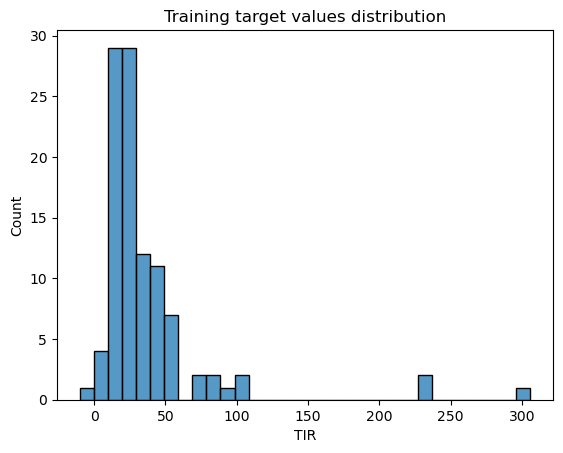

In [7]:
ax = sns.histplot(y_train)
ax.set_title("Training target values distribution")

In [8]:
#Removing IRR/TIR outliers (>125) from the training dataset
X_train = X_train[y_train < UPPER_LIMIT_TIR]
y_train = y_train[y_train < UPPER_LIMIT_TIR]


train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

#Classification of unpromising projects, class tagerts
y_train_cat = y_train < MIN_TIR
y_test_cat = y_test < MIN_TIR

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train_cat = pd.DataFrame(y_train_cat)
y_test_cat = pd.DataFrame(y_test_cat)

print("Data shapes")
print(X_train.shape)
print(X_test.shape)

Data shapes
(100, 27)
(94, 27)


In [9]:
#Asserting the target distribution
y_train_cat.value_counts(normalize=True)

TIR  
False    0.85
True     0.15
Name: proportion, dtype: float64

In [10]:
# Mean of missing values in the training dataset per column
(X_train.isnull().sum()/X_train.shape[0]).mean()

0.02370370370370371

# Saving

In [12]:
raw_copper_mines_df.to_parquet("../../../../data/processed/copper/copper_data.parquet")
train_df.to_parquet("../../../../data/processed/copper/train_data.parquet")
test_df.to_parquet("../../../../data/processed/copper/test_data.parquet")
X_train.to_parquet("../../../../data/interim/copper/X_train.parquet")
X_test.to_parquet("../../../../data/interim/copper/X_test.parquet")
y_train.to_parquet("../../../../data/interim/copper/y_train.parquet")
y_test.to_parquet("../../../../data/interim/copper/y_test.parquet")
y_train_cat.to_parquet("../../../../data/interim/copper/y_train_cat.parquet")
y_test_cat.to_parquet("../../../../data/interim/copper/y_test_cat.parquet")